In [1]:
#Install Model Requirements
!pip3 install -r requirements.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [3]:
# Import packages
import argparse
import os
from datetime import datetime as dt

import gym
from stable_baselines import PPO2
from stable_baselines.common.policies import MlpPolicy
from stable_baselines.common.vec_env import SubprocVecEnv

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



In [4]:
import reco_env
import test_reco_env
import utils

In [5]:
from gym.envs.registration import register
from reco_env import RecoEnv
from utils import import_data_for_env, evaluate


register(
    id=RecoEnv.id,
    entry_point='reco_env:RecoEnv',
    max_episode_steps=1000000,
    nondeterministic=False
)

In [6]:
start_time = dt.now()
number_of_cpu = os.cpu_count()
envs = SubprocVecEnv([lambda: gym.make(reco_env.RecoEnv.id, **utils.import_data_for_env())
                      for _ in range(number_of_cpu)])

Starting data download. Saving to /content/data
Using cached data located at /content/data/ml-100k.
Starting data download. Saving to /content/data
Using cached data located at /content/data/ml-100k.


Model config

In [7]:
ppo_configs = {
    'learning_rate': 3e-4,  # lambda f: f * float(3e-4),
    'n_steps': 64,
    'tensorboard_log': "./tensorboard",
    'nminibatches': min(number_of_cpu, 4),
    'noptepochs': number_of_cpu,
    'gamma': 0.0,
    'ent_coef': 0.01,
    'vf_coef': 0.5,
    'max_grad_norm': 0.5,
    'lam': 0.95,
    'cliprange': 0.3,
    'verbose': 1,
    '_init_setup_model': True
}
print('*********************************')
print("ppo_configs:", ppo_configs)
print('*********************************')

*********************************
ppo_configs: {'learning_rate': 0.0003, 'n_steps': 64, 'tensorboard_log': './tensorboard', 'nminibatches': 2, 'noptepochs': 2, 'gamma': 0.0, 'ent_coef': 0.01, 'vf_coef': 0.5, 'max_grad_norm': 0.5, 'lam': 0.95, 'cliprange': 0.3, 'verbose': 1, '_init_setup_model': True}
*********************************


In [8]:
# import required modules
import inspect
import collections
  
# use signature()
print(inspect.signature(PPO2))

(policy, env, gamma=0.99, n_steps=128, ent_coef=0.01, learning_rate=0.00025, vf_coef=0.5, max_grad_norm=0.5, lam=0.95, nminibatches=4, noptepochs=4, cliprange=0.2, verbose=0, tensorboard_log=None, _init_setup_model=True)


## Training the Model

In [9]:
model = PPO2(policy="MlpPolicy", env=envs, **ppo_configs)
model.learn(total_timesteps=100000)
elapsed = (dt.now() - start_time).seconds
print(f"Finished training in {elapsed} seconds")

Streaming output truncated to the last 5000 lines.
| time_elapsed       | 59.8          |
| total_timesteps    | 57472         |
| value_loss         | 0.24920715    |
--------------------------------------
--------------------------------------
| approxkl           | 9.2765284e-10 |
| clipfrac           | 0.0           |
| ep_rewmean         | nan           |
| eplenmean          | nan           |
| explained_variance | -0.0184       |
| fps                | 926           |
| nupdates           | 450           |
| policy_entropy     | 0.014522608   |
| policy_loss        | 7.2689727e-07 |
| serial_timesteps   | 28800         |
| time_elapsed       | 59.9          |
| total_timesteps    | 57600         |
| value_loss         | 0.22670281    |
--------------------------------------
-------------------------------------
| approxkl           | 3.544737e-12 |
| clipfrac           | 0.0          |
| ep_rewmean         | nan          |
| eplenmean          | nan          |
| explained_varian

In [10]:
if True:
    save_name = 'PPO2_Recommendations'
    print(f'Saving PPO model as {save_name}')
    model.save(save_name)

Saving PPO model as PPO2_Recommendations


Evaluation of Model

In [11]:
utils.evaluate(model=model,env=gym.make(reco_env.RecoEnv.id,**utils.import_data_for_env()),num_steps=10000)
elapsed = (dt.now() - start_time).seconds
print(f"Finished training AND evaluation in {elapsed} seconds")

Starting data download. Saving to /content/data
Using cached data located at /content/data/ml-100k.
Reco is being reset() --> first step = 0 | Total_correct = 0
Finished training AND evaluation in 135 seconds


In [12]:
import tensorflow as tf

In [13]:
loss_all = []
for e in tf.train.summary_iterator('/content/tensorboard/PPO2_1/events.out.tfevents.1654728087.d7237c28801d'):
    for v in e.summary.value:
      #print(v)
      if v.tag == 'loss/entropy_loss':
        loss_all.append(v.simple_value)

Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


Loss Plot

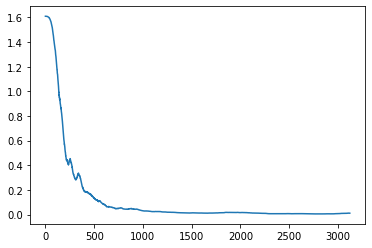

In [14]:
from matplotlib import pyplot as plt
plt.plot(loss_all)
plt.show()

## Test Observation

In [19]:
%run test_reco_env.py

Starting data download. Saving to /content/data
Using cached data located at /content/data/ml-100k.
Reco is being reset() --> first step = 0 | Total_correct = 0
Env observation at step 4999 is 
[0.60618556 0.82       0.         0.         0.         0.
 0.         1.         0.         0.         0.         0.
 0.         0.         0.         0.         1.         0.
 0.         0.         0.         0.         0.         1.
 0.         0.         0.         0.         0.         0.
 1.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         1.         0.        ]
Env observation at step 9999 is 
[0.7882353 0.728839  0.        1.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        1.        0.        0.
 0.        0.        0.        1.        0.        0.        0.
 0.       